# [GD-06] GO/STOP! - Object Detection 시스템 만들기


### 목차 

    (1) 라이브러리 import 및 버전 확인
    (2) 데이터 준비 / 전처리
    (3) 모델 구성하기
    (4) 모델 학습하기 
    (5) 시각화


### (1) 라이브러리 import

In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

print('슝=3')

슝=3


- GPU 연결 확인

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### (2) 데이터 준비 & 전처리

In [3]:
DATA_DIR = 'object_detection/data'

In [4]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_DIR,
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


- 데이터셋 features 확인
    - image: 입력 이미지 인덱스
    - objects
        - alpha: Observation angle of object, ranging [-pi..pi]
        - bbox
            - 바운딩 박스: 물체의 위치를 사각형 영역으로 표기하는 방법
            - BBoxFeature 타입
            - minmax 방식
            - 2D bounding box of object in the image (0-based index): contains left, top, right, bottom pixel coordinates
        - dimensions: 3D object dimensions: height, width, length (in meters)
        - location: 3D object location x,y,z in camera coordinates (in meters)
        - occluded
            - Integer (0,1,2,3) indicating occlusion state: 0 = fully visible, 1 = partly occluded, 2 = largely occluded, 3 = unknown
        - rotation_y: Rotation ry around Y-axis in camera coordinates [-pi..pi]
        - truncated: Float from 0 (non-truncated) to 1 (truncated), where truncated refers to the object leaving image boundaries
        - type: 정답 클래스 인덱스
            - Describes the type of object: 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc' or 'DontCare'

In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/file_name': Text(shape=(), dtype=tf.string),
    'objects': Sequence({
        'alpha': tf.float32,
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'dimensions': Tensor(shape=(3,), dtype=tf.float32),
        'location': Tensor(shape=(3,), dtype=tf.float32),
        'occluded': ClassLabel(shape=(), dtype=tf.int64, num_classes=4),
        'rotation_y': tf.float32,
        'truncated': tf.float32,
        'type': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
})


- 데이터셋 클래스 개수 및 구성 확인

In [6]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(6347, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_val))  # tf.Tensor(423, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(711, shape=(), dtype=int64)

tf.Tensor(6347, shape=(), dtype=int64)
tf.Tensor(423, shape=(), dtype=int64)
tf.Tensor(711, shape=(), dtype=int64)


In [7]:
NUM_CLASSES = ds_info.features["objects"]["type"].num_classes
NUM_CLASSES  # 8

8

In [8]:
TYPE_NAMES = ds_info.features["objects"]["type"].names
TYPE_NAMES

['Car',
 'Van',
 'Truck',
 'Pedestrian',
 'Person_sitting',
 'Cyclist',
 'Tram',
 'Misc']

- 각 이미지 클래스와 인덱스 확인
    - 학습용 데이터셋 확인
    - 검증용 데이터셋 확인
    - 테스트 데이터셋 확인

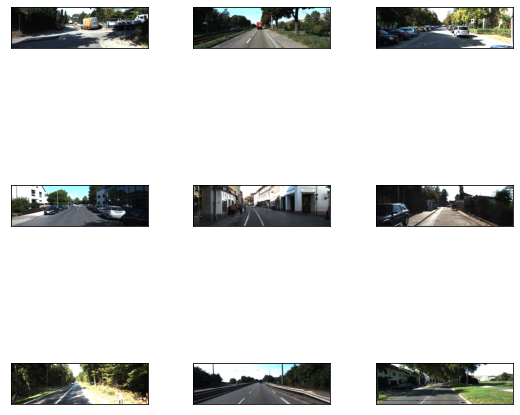

In [9]:
_ = tfds.show_examples(ds_train, ds_info)

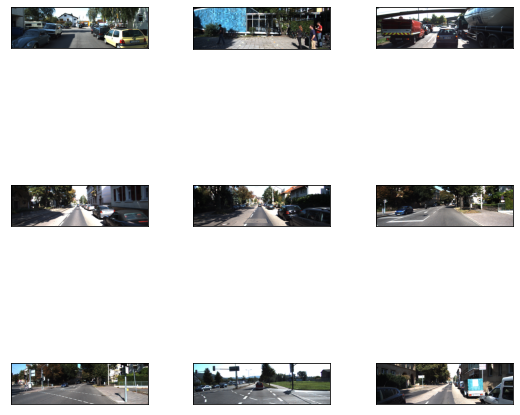

In [10]:
_ = tfds.show_examples(ds_val, ds_info)

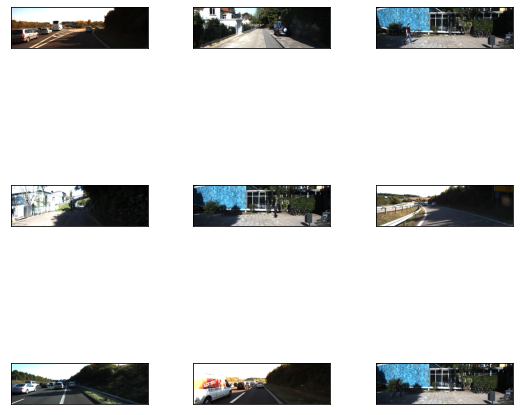

In [11]:
_ = tfds.show_examples(ds_test, ds_info)

In [12]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': 

- 학습용 이미지 확인

In [13]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))  # ['image', 'image/file_name', 'objects']
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(12,), dtype=float32, numpy=
array([-1.62,  2.83,  1.8 ,  1.21,  1.37, -1.62, -1.73, -1.72, -1.67,
       -1.75, -1.83,  1.7 ], dtype=float32)>, 'bbox': <tf.Tensor: shape=(12, 4), dtype=float32, numpy=
array([[0.19759358, 0.58719707, 0.55085564, 0.6294669 ],
       [0.27114972, 0.32868335, 0.5514439 , 0.35911146],
       [0.27885026, 0.27380452, 0.54676473, 0.29965267],
       [0.28427806, 0.71238285, 0.5624064 , 0.7430775 ],
       [0.29352942, 0.67714864, 0.5678075 , 0.7126898 ],
       [0.36010695, 0.526147  , 0.5528342 , 0.55037963],
       [0.21764706, 0.59163976, 0.5323529 , 0.6223344 ],
       [0.2614706 , 0.5731422 , 0.53770053, 0.6131745 ],
       [0.28641713, 0.56429726, 0.534385  , 0.58663976],
       [0.3193583 , 0.6290549 , 0.5640909 , 0.6557108 ],
       [0.36435828, 0.63436186, 0.56671125, 0.6585945 ],
       [0.43617648, 0.44625202, 0.5323262 , 0.4839903 ]], dtype

(1238, 374)


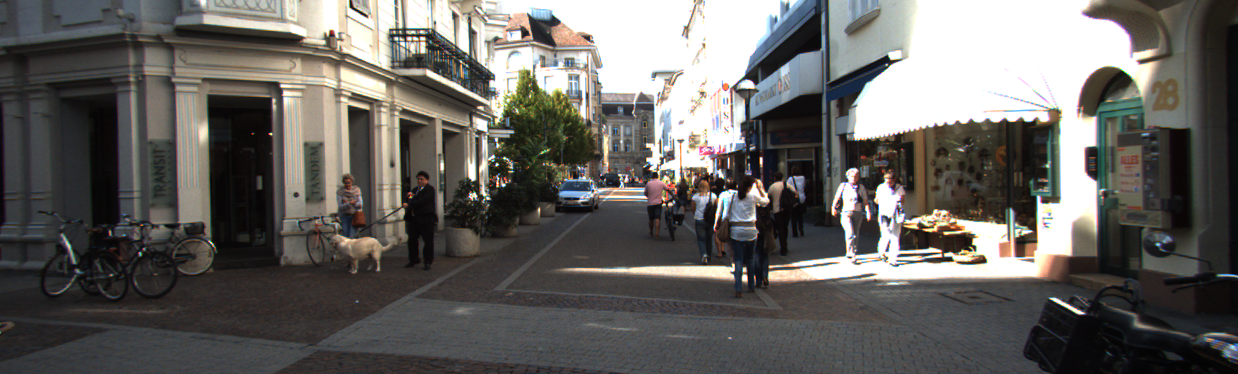

In [14]:
img = Image.fromarray(image.numpy())
print(img.size)
img

- 바운딩 박스 시각화

In [15]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

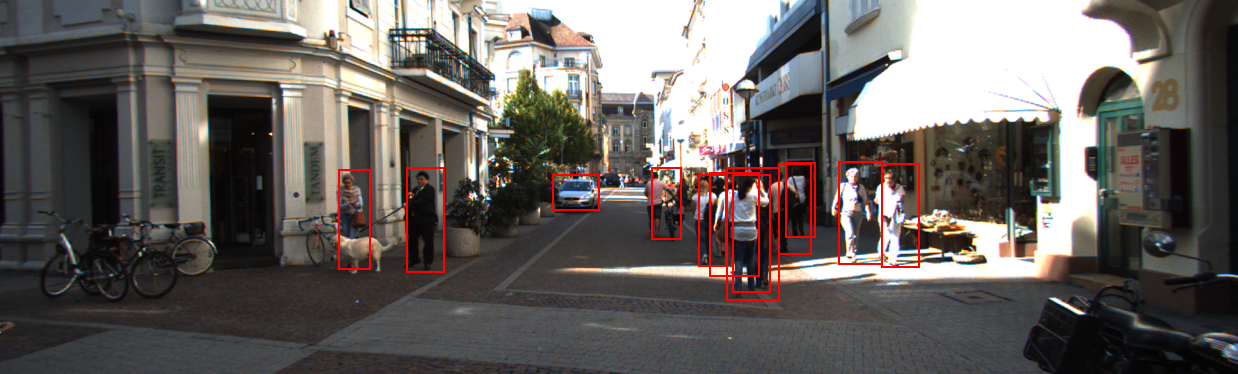

In [16]:
visualize_bbox(img, objects['bbox'].numpy())

### 이미지 전처리

- x와 y좌표 위치 교체

In [17]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

print('슝=3')

슝=3


- 무작위로 수평 뒤집기(Flip)

In [18]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

print('슝=3')

슝=3


- 이미지 크기 조정 및 패딩 추가
    - 이미지의 비율은 그대로 유지
    - 이미지의 최대/최소 크기 제한
    - 모델에 입력되는 이미지 크기 = stride 의 배수
    - 이미지에 패딩을 더해 모델에 입력되는 이미지에는 검정 테두리가 있게 됨

In [19]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('슝=3')

슝=3


- 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

In [20]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

print('슝=3')

슝=3


- 데이터 가공 함수

In [21]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('슝=3')

슝=3


### One stage detector - RetinaNet 사용
- Anchor Box 라는 정해져 있는 위치, 크기, 비율 중에 하나로 물체의 위치가 결정됨
    - Anchor Box로 생성되는 것 == 물체 위치 후보

- AnchorBox 클래스

In [22]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('슝=3')

슝=3


- 입력할 데이터를 Anchor Box에 맞게 변형하는 함수

In [23]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

- IoU 계산 함수
    - IoU가 높은지 낮은지에 따라 Anchor Box가 정답인지 오답인지 체크

In [24]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('슝=3')

슝=3


- 라벨 인코딩 클래스
    - 라벨을 Anchor Box 에 맞추는 클래스
    - IoU 를 기준으로 물체에 해당하는 Anchor Box 와 배경이 되는 Anchor Box 지정 -> Anchor Box 와 실제 Bounding Box 의 차이 계산해서 상하좌우/가로세로 크기 차이를 로그로 기록
        - 물체: IoU 0.5 보다 높은 경우
        - 배경: IoU 0.4 보다 낮은 경우
    - variance
        - 상하좌우 차이 0.1, 가로세로 크기 차이 0.2 사용
        - 통계적 추정치를 계산할 때 분산으로 나눠주는 것 때문이라는 의견 있음

In [25]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('슝=3')

슝=3


In [26]:
BATCH_SIZE = 2

- 데이터 전처리를 위한 파이프라인 생성

In [27]:
label_encoder = LabelEncoder()

autotune = tf.data.AUTOTUNE
ds_train = ds_train.map(preprocess_data, num_parallel_calls=autotune)
ds_train = ds_train.shuffle(8 * BATCH_SIZE)
ds_train = ds_train.padded_batch(
    batch_size=BATCH_SIZE, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
ds_train = ds_train.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
ds_train = ds_train.prefetch(autotune)

ds_val = ds_val.map(preprocess_data, num_parallel_calls=autotune)
ds_val = ds_val.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
ds_val = ds_val.map(label_encoder.encode_batch, num_parallel_calls=autotune)
ds_val = ds_val.prefetch(autotune)

print('슝=3')

슝=3


### 모델 작성

- 모델 작성
    - RetinaNet
        - FPN(Feature Pyramid Network) 약간 수정해서 사용

In [28]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output


- head 생성 함수
    - Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요 => head
        - class를 예측하는 head
        - box를 예측하는 head

In [29]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head


- ResNet50
    - RetinaNet 의 backbone
    - FPN 에 이용할 수 있도록 중간 레이어를 output 으로 연결

In [30]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('슝=3')

슝=3


- RetinaNet 클래스
    - Backbone + FPN + classification용 head + box용 head

In [31]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('슝=3')

슝=3


- RetinaNet Loss 클래스
    - Classification Loss를 계산하는데만 Focal Loss 사용
    - cf. 참고
        - Box Regression
            - Smooth L1 Loss 사용
            - delta를 기준으로 계산이 달라짐
        - Classification Loss
            - Focal Loss 사용
            - alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라짐

In [32]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('슝=3')

슝=3


### 모델 학습

- 모델 학습 준비

In [33]:
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(NUM_CLASSES)
model = RetinaNet(NUM_CLASSES, resnet50_backbone)

print('슝=3')

슝=3


- Learning Rate 설정
    - 논문에서는 8개의 GPU를 사용했기 때문에 적절히 바꿔야 함
    - Optimizer SGD 사용

In [34]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

- 모델 학습
    - 1 epoch당 학습 시간이 상당히 오래 걸림
    - 미리 학습된 모델을 불러와 사용할 예정

In [35]:
EPOCHS = 20

In [36]:
MODEL_DIR = os.path.join(DATA_DIR, 'checkpoints') 
MODEL_PATH = os.path.join(MODEL_DIR)

In [37]:
def model_fit(model, model_path):
  
    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=EPOCHS,
       
    )

    return history

In [1]:
history = model_fit(model, MODEL_PATH)

NameError: name 'model_fit' is not defined

- 학습 결과 시각화

In [ ]:
def draw_history(history):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.show()

draw_history(history)

In [ ]:
draw_history(history)

- 학습한 모델 저장

model.save_weights(MODEL_PATH)
print("Save Model")

In [ ]:
#model.save_weights(MODEL_PATH) 
#print("Save Model")

### 결과 확인

- 학습된 모델 불러옴

- 모델의 추론 결과를 처리할 함수를 레이어 형식으로 생성
    - 현재 구현으로는 100개의 후보만 골라 처리할 예정
        - 논문: 0.05보다 높은 box 1000개를 골라 0.5 NMS 진행
    - NMS(Non-Max Suppression)
        - [tf.image.combined_non_max_suppression()](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression) 사용
        - 출력 nmsed_boxes, nmsed_scores, nmsed_classes, valid_detections 이 각각 무엇인지 알아야 함!

In [ ]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )


- 추론 가능한 모델 조립

In [ ]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)



- 모델 추론 결과 시각화 함수

In [ ]:
car_list = ['Car', 'Van', 'Truck', 'Tram']
people_list = ['Pedestrian', 'Person_sitting', 'Cyclist']

In [ ]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(12, 4), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)

    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):

        if _cls in car_list:
            color=[0,1,1]  # 객체가 차량일 경우, 하늘색 설정
        elif _cls in people_list:
            color = [1,1,0]  # 객체가 사람일 경우, 노란색 설정

        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax



- 추론시 입력 데이터를 전처리 하기 위한 함수
    - 학습을 위한 전처리와 다름!

In [ ]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

- Object Detection 결과 시각화

In [ ]:
def get_object_detection_result(image):
    int2str = ds_info.features["objects"]["type"].int2str

    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]

    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    scores = detections.nmsed_scores[0][:num_detections]

    return image, boxes, class_names, scores

In [ ]:
for sample in ds_test.take(2):
    visualize_detections(*get_object_detection_result(sample["image"]))

---

### 1. 자율주행 시스템 만들기

위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

- 입력으로 이미지 경로를 받습니다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
- 조건은 다음과 같습니다.
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우

In [ ]:
def self_drive_assist(image_path,
                    size_limit=300, to_visualize=False,
                    people_list = ['Pedestrian', 'Person_sitting', 'Cyclist']
):
    image = Image.open(image_path).convert('RGB')
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image, boxes, class_names, scores = get_object_detection_result(image)

    # 시각화
    if to_visualize:
        visualize_detections(image, boxes, class_names, scores)

    # 정지조건 1: 사람 한 명 이상 있는 경우 "Stop"
    if len(set(class_names) & set(people_list)) > 0:
        return "Stop"

    # 정지조건 2: 차량 크기(W,H)가 300px 이상인 경우 "Stop"
    for box, class_name, score in zip(boxes, class_names, scores):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        # print(f"w {w:.2f}, h {h:.2f}, w*h {w*h:.2f}")  # 자동차 크기 출력
        if w >= size_limit or h >= size_limit:
            return "Stop"
            
    # 아니면 "Go"
    return "Go"

In [ ]:
image_path_list = [image_path for image_path in os.listdir(DATA_DIR) if image_path.endswith('.png')]

for i, image_path in enumerate(image_path_list):
    print(i, image_path)
    print(self_drive_assist(os.path.join(DATA_DIR, image_path), size_limit=300, to_visualize=True))
    print('━━━━━━━━━━━━━━━')

### 2. 자율주행 시스템 평가하기
아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [ ]:
def test_system(func, data_dir):
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = os.path.join(data_dir, image_file)
        pred = func(image_path)
        if pred == answer:
            score += 10
        print(f'pred: {pred}, answer: {answer}, score: {score}')
    
    print(f"\n***** {score}점입니다. *****")

In [ ]:
test_system(self_drive_assist, DATA_DIR)

---

# 회고

- 데이터셋이 커서 그런지 학습 시간이 오래 걸렸다.
- Object Detection 한 결과를 바운딩 박스로 그려내는 부분이 이상하다. 제대로 된 위치에 그려질 때도 있고 아닐 때도 있다. 정말 고치고 싶었지만.. 다음 노드가 날 기다리고 있기 때문에 넘어가야겠다.
- Forum 에 누가 바운딩 박스가 잘못 그려지는 것에 대한 문의글을 올려서 Editor 분께서 노드를 수정했다고 하셨다. 그래서 수정한 코드로 다시 학습시킨 결과 제대로 된 위치에 바운딩 박스가 그려지는 것을 확인했다. 해결 완료!




#### 목표 

|번호|평가문항|상세기준|
|:---:|---|---|
|1|KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.|KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행였다.|
|2|RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.|바운딩박스가 정확히 표시된 시각화된 이미지를 생성하다.|
|3|자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.|테스트 수행결과 90% 이상의 정확도를 보였다.|

<br> 

KITTI 데이터셋은 다른 텐서플로우 제공 데이터셋과 다르게 정답 클래스 인덱스가 'label' 이 아니고 'objects' 안의 'type'으로 들어가 있었다. 자율주행에 대한 데이터셋 답게 여러 특징이 있었다. 

RetinaNet 학습을 진행해서 Object Detection 을 수행했다. early stopping 을 걸었더니 너무 일찍 학습이 끝나서 객체 검출 결과가 썩 좋지 않았다. 그래서 주석 처리하고 epochs=15 로 다시 학습시켜서 결과물로 제출했다. 학습 그래프를 시각화해보고 **사람이면 노란색으로, 차량이면 하늘색으로 바운딩 박스** 를 그려보았다.

정지 조건(사람이 있느냐, 차량 크기가 300px 이상인가)으로 노드 제공 테스트 이미지 10장에 대해 수행해 본 결과 90점이 나왔다. 테스트 이미지를 더 추가해서 확인하면 값이 다르게 나올 수 있지만 어쨌든 정확도 90% 를 볼 수 있었다. 조건을 더 세부적으로 걸어야 할 필요가 느껴졌다. **go_3.png 결과를 보면 검출한 객체 중에 사람이 있느냐만 판별해서 저 멀리 횡단보도에 있는 자전거 타는 사람 때문에 stop 이 되었다. 사람이 어느 정도 멀리 위치하느냐(=바운딩 박스 크기가 작은 정도)에 따라 정지할 것인지 말 것인지 정하면 더 좋을 것이란 생각이 들었다.**

